# A/B Testing Analysis

**Objective:** Perform statistical analysis on control and treatment groups to assess impact of a change (e.g., pricing, UI, landing page).

**Outcome:** Data-driven recommendation whether to implement the new change.

This notebook includes: data loading, cleaning, exploratory analysis, conversion rate calculations, z-test and chi-square test, confidence intervals, and visualizations.


In [2]:

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from datetime import datetime

# Display settings
pd.set_option('display.max_columns', 50)
plt.rcParams['figure.figsize'] = (8,5)


In [3]:

# Load the dataset (adjust path if needed)
file_path = "/mnt/data/ab_data.csv"
df = pd.read_csv("C:\\Users\\hp\\Downloads\\Task3(ABTesting)\\ab_data.csv")
df.head()


,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


## 1. Data Cleaning and Validation

- Check for missing values
- Ensure landing_page matches group (control -> old_page, treatment -> new_page)
- Remove inconsistent rows if any


In [4]:

# Basic info and missing values
df.info()
print('\nMissing values per column:\n', df.isnull().sum())

# Check consistency between group and landing_page
inconsistent = df[~(((df['group']=='control') & (df['landing_page']=='old_page')) | 
                    ((df['group']=='treatment') & (df['landing_page']=='new_page')))]
print('\nNumber of inconsistent rows:', len(inconsistent))
inconsistent.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB

Missing values per column:
 user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

Number of inconsistent rows: 3893


,user_id,timestamp,group,landing_page,converted
22,767017,2017-01-12 22:58:14.991443,control,new_page,0
240,733976,2017-01-11 15:11:16.407599,control,new_page,0
308,857184,2017-01-20 07:34:59.832626,treatment,old_page,0
327,686623,2017-01-09 14:26:40.734775,treatment,old_page,0
357,856078,2017-01-12 12:29:30.354835,treatment,old_page,0


In [5]:

# Remove inconsistent rows (if any)
df_clean = df.copy()
df_clean = df_clean[((df_clean['group']=='control') & (df_clean['landing_page']=='old_page')) | 
                    ((df_clean['group']=='treatment') & (df_clean['landing_page']=='new_page'))].reset_index(drop=True)
print('Rows before:', len(df), 'Rows after cleaning:', len(df_clean))


Rows before: 294478 Rows after cleaning: 290585


## 2. Define Control and Treatment Groups

We'll compute conversion rates and sample sizes for each group.

In [6]:

# Group summary
summary = df_clean.groupby('group').agg(
    n_users = ('user_id', 'count'),
    conversions = ('converted', 'sum')
).reset_index()
summary['conversion_rate'] = summary['conversions'] / summary['n_users']
summary


,group,n_users,conversions,conversion_rate
0,control,145274,17489,0.120386
1,treatment,145311,17264,0.118807


## 3. Conversion Rate Comparison

Calculate the difference in conversion rates and visualize.

In [7]:

# Conversion rates and difference
control = summary[summary['group']=='control'].iloc[0]
treatment = summary[summary['group']=='treatment'].iloc[0]

p_control = control['conversion_rate']
p_treatment = treatment['conversion_rate']
n_control = control['n_users']
n_treatment = treatment['n_users']

diff = p_treatment - p_control
print(f"Control conversion rate: {p_control:.4f} ({control['conversions']}/{n_control})")
print(f"Treatment conversion rate: {p_treatment:.4f} ({treatment['conversions']}/{n_treatment})")
print(f"Difference (treatment - control): {diff:.4f}")


Control conversion rate: 0.1204 (17489/145274)
Treatment conversion rate: 0.1188 (17264/145311)
Difference (treatment - control): -0.0016


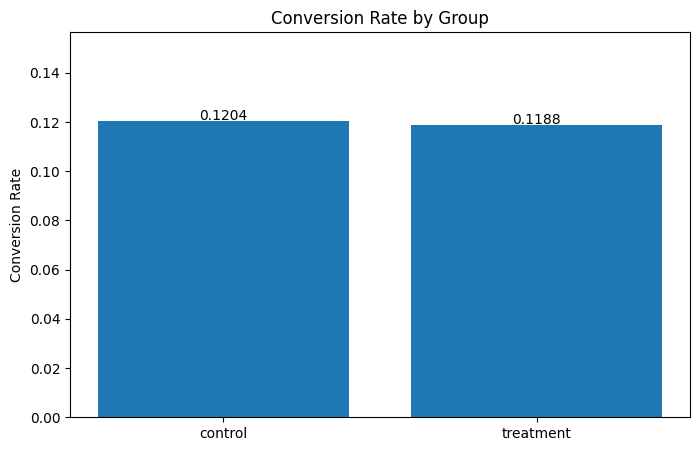

In [8]:

# Bar plot of conversion rates
groups = ['control','treatment']
rates = [p_control, p_treatment]
plt.bar(groups, rates)
plt.ylabel('Conversion Rate')
plt.title('Conversion Rate by Group')
for i, v in enumerate(rates):
    plt.text(i, v + 0.0005, f"{v:.4f}", ha='center')
plt.ylim(0, max(rates)*1.3)
plt.show()


## 4. Statistical Tests

We'll perform:
- Two-proportion z-test for difference in conversion rates
- Chi-square test of independence (conversion vs group)

We will also compute a 95% confidence interval for the difference in proportions.

In [9]:

# Two-proportion z-test (manual calculation)
p_pool = (control['conversions'] + treatment['conversions']) / (n_control + n_treatment)
se_pool = np.sqrt(p_pool * (1 - p_pool) * (1/n_control + 1/n_treatment))
z_stat = (p_treatment - p_control) / se_pool
p_value_two_sided = 2 * (1 - stats.norm.cdf(abs(z_stat)))

print(f"Pooled proportion: {p_pool:.6f}")
print(f"Z-statistic: {z_stat:.4f}")
print(f"Two-sided p-value: {p_value_two_sided:.6f}")


Pooled proportion: 0.119597
Z-statistic: -1.3116
Two-sided p-value: 0.189653


In [10]:

# 95% confidence interval for difference in proportions (unpooled)
se_diff = np.sqrt(p_control*(1-p_control)/n_control + p_treatment*(1-p_treatment)/n_treatment)
z_95 = stats.norm.ppf(0.975)
ci_lower = diff - z_95 * se_diff
ci_upper = diff + z_95 * se_diff
print(f"95% CI for difference (treatment - control): [{ci_lower:.6f}, {ci_upper:.6f}]")


95% CI for difference (treatment - control): [-0.003939, 0.000781]


In [11]:

# Chi-square test (conversion vs group)
contingency = pd.crosstab(df_clean['group'], df_clean['converted'])
contingency.columns = ['not_converted','converted']
contingency


,not_converted,converted
group,,
control,127785,17489
treatment,128047,17264


In [12]:

chi2, chi_p, dof, expected = stats.chi2_contingency(contingency)
print(f"Chi-square statistic: {chi2:.4f}, p-value: {chi_p:.6f}, dof: {dof}")
print('\nExpected frequencies:\n', expected)


Chi-square statistic: 1.7054, p-value: 0.191590, dof: 1

Expected frequencies:
 [[127899.7125385  17374.2874615]
 [127932.2874615  17378.7125385]]


## 5. Practical Significance (Effect Size)

We'll compute the absolute difference and relative uplift.

In [13]:

absolute_diff = diff
relative_uplift = (p_treatment / p_control - 1) if p_control > 0 else np.nan
print(f"Absolute difference: {absolute_diff:.6f}")
print(f"Relative uplift: {relative_uplift:.4%}")


Absolute difference: -0.001579
Relative uplift: -1.3117%


## 6. Summary and Recommendation

Interpret results and provide a recommendation based on statistical significance and business impact.

In [14]:

alpha = 0.05
print('Statistical significance threshold alpha =', alpha)
print('\nTwo-proportion z-test p-value =', p_value_two_sided)
print('Chi-square test p-value =', chi_p)
print('\n95% CI for difference:', (ci_lower, ci_upper))
print(f"\nRecommendation guidance:")
if p_value_two_sided < alpha:
    print('- The difference is statistically significant at alpha=0.05.')
else:
    print('- The difference is NOT statistically significant at alpha=0.05.')

print('\nConsiderations:')
print('- Check business impact of the observed uplift (absolute and relative).')
print('- Consider running longer or segmenting by user cohorts if result is marginal.')


Statistical significance threshold alpha = 0.05

Two-proportion z-test p-value = 0.18965258971881793
Chi-square test p-value = 0.19158976298516003

95% CI for difference: (np.float64(-0.003938670329636228), np.float64(0.0007805571342619382))

Recommendation guidance:
- The difference is NOT statistically significant at alpha=0.05.

Considerations:
- Check business impact of the observed uplift (absolute and relative).
- Consider running longer or segmenting by user cohorts if result is marginal.


## 7. (Optional) Bootstrapped Confidence Interval

We'll run a bootstrap to estimate the confidence interval for the difference of conversion rates.

In [15]:

# Bootstrap for difference in conversion rates
rng = np.random.default_rng(42)
n_iters = 10000
boot_diffs = np.empty(n_iters)
arr_control = df_clean[df_clean['group']=='control']['converted'].values
arr_treatment = df_clean[df_clean['group']=='treatment']['converted'].values

for i in range(n_iters):
    s_control = rng.choice(arr_control, size=len(arr_control), replace=True)
    s_treatment = rng.choice(arr_treatment, size=len(arr_treatment), replace=True)
    boot_diffs[i] = s_treatment.mean() - s_control.mean()

ci_lower_b = np.percentile(boot_diffs, 2.5)
ci_upper_b = np.percentile(boot_diffs, 97.5)
print(f"Bootstrap 95% CI: [{ci_lower_b:.6f}, {ci_upper_b:.6f}]")


Bootstrap 95% CI: [-0.003953, 0.000782]


## 8. Save results to CSV (summary)

We'll save a small summary CSV with key metrics.

In [17]:

results = {
    'group': ['control','treatment'],
    'n_users': [n_control, n_treatment],
    'conversions': [int(control['conversions']), int(treatment['conversions'])],
    'conversion_rate': [p_control, p_treatment]
}
res_df = pd.DataFrame(results)
res_df['conversion_rate'] = res_df['conversion_rate'].round(6)
out_path = "C:\\Users\\hp\\Downloads\\Task3(ABTesting)\\countries (1).csv"
res_df.to_csv(out_path, index=False)
print('Saved summary to', out_path)
res_df


Saved summary to C:\Users\hp\Downloads\Task3(ABTesting)\countries (1).csv


,group,n_users,conversions,conversion_rate
0,control,145274,17489,0.120386
1,treatment,145311,17264,0.118807
